In [2]:
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
from scipy.interpolate import interpn

#### Decoding bilateral filtering 
Eq. 6 from fast bilateral filtering: 
$$J_s = \frac{1}{k(s)} \Sigma_{p \in \pi} f(p - s) g(I_p - I_s) I_p$$

Eq. 4 of Flash paper:
<br>
Joint bilateral filter: 
$$A_{NR} = \frac{1}{k(s)} \Sigma_{p \in \pi} f(p - s) g(F_p - F_s) I_p$$

for a fixed pixel $s$, 


In [3]:
def normalize(img):
    return (img - img.min())/(img.max() - img.min())

In [9]:
ambient = skimage.io.imread('data/Mine/DSC_0207.JPG')
flash = skimage.io.imread('data/Mine/DSC_0208.JPG')
print(ambient.shape, flash.shape)
print(ambient.min(), ambient.max())

Aimg = normalize(ambient)
Flash_img = normalize(flash)
print(Aimg.min(), Aimg.max())
print(Flash_img.min(), Flash_img.max())

(4000, 6000, 3) (4000, 6000, 3)
0 255
0.0 1.0
0.0 1.0


In [15]:
def plot_fig(fig1, fig2, name='img_temp.png', title1=None, title2=None):
    fig = plt.figure(figsize=(14, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight')
    plt.show()

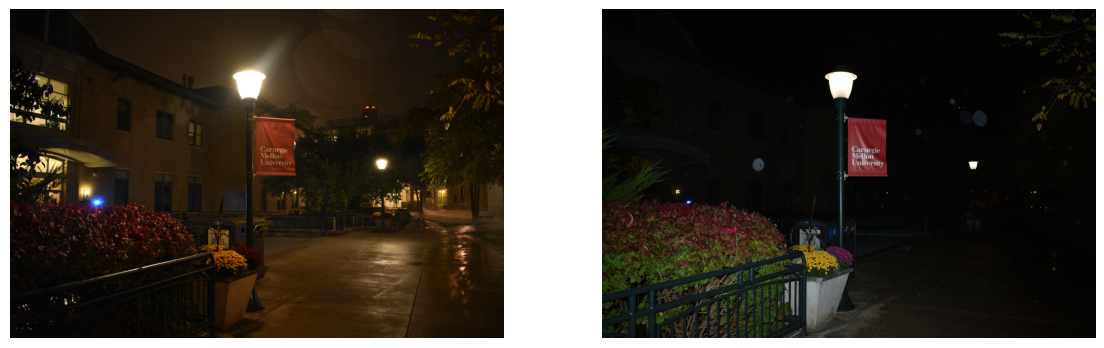

In [16]:
plot_fig(Aimg, Flash_img)

In [17]:
# hyperparameters
lamda = 0.01

def gaussian_blur(img, sigma):
    return cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)

In [18]:
def piecewise_bilateral(A_ambient, A_flash, sigma_r, sigma_s):
    H, W, c = A_ambient.shape
    min_I = A_flash.min() - lamda
    max_I = A_flash.max() + lamda 
    NBSeg = int(np.ceil((max_I - min_I)/sigma_r)) # compute using flash img in Joint
    print(NBSeg, H, W)
    '''
    Apply filter over each channel of ambient image A separately!
    '''
    Output = []
    for i in range(c):
        A = A_ambient[:, :, i]
        F = A_flash[:, :, i]
        J = []
        for j in range(NBSeg+1):
            i_j = min_I + j * ((max_I - min_I)/NBSeg) # compute using flash img in Joint
            # print(i_j)
            # use Ambient image as I hereon
            G_j = gaussian_blur((F - i_j), sigma_r)
            K_j = gaussian_blur(G_j, sigma_s)
            # print(f'G_j, {G_j.shape}, A {A.shape}')
            H_j = np.multiply(G_j, A)
            H_star_j = gaussian_blur(H_j, sigma_s)
            # print(f'H_star_j {H_star_j.shape}, K_j {K_j.shape}')
            J_j = H_star_j / K_j
            # print(f'J_j {J_j.min()}, {J_j.max()}')
            J.append(J_j)
        # print(len(J))
        # apply interpolation function here
        J_channel = np.stack(J, axis=2)
        # print(J_channel.shape, J_channel.min(), J_channel.max())
        X = np.arange(H)
        Y = np.arange(W)
        Z = np.arange(NBSeg+1)
        points = (X, Y, Z)
        # print(points)
        sample_at = np.meshgrid(X, Y, indexing='ij')
        sample_at = np.stack(sample_at, axis=2)
        # print('sample at', sample_at.shape, A.shape)
        sample_at = np.concatenate((sample_at, np.expand_dims(A, axis=2)), axis=2)
        # print('sample at', sample_at.shape)
        
        J_filtered_channel = interpn(points, J_channel, sample_at)
        print(f'J_filtered_channel {J_filtered_channel.shape, J_filtered_channel.min(), J_filtered_channel.max()}')
        Output.append(J_filtered_channel)
    Output = np.stack(Output, axis=2)
    return Output

### Joint bilateral filter 

11 4000 6000
J_filtered_channel ((4000, 6000), -13008.017964222161, 1973.6559573293823)
J_filtered_channel ((4000, 6000), -2343.2931477456873, 2479.4536416802844)
J_filtered_channel ((4000, 6000), -586.7930246749066, 6078.149851983388)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


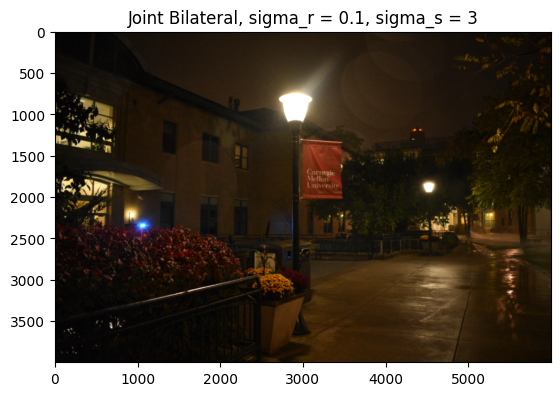

In [19]:
# My images 
sigma_s = 3
sigma_r = 0.1
jb = piecewise_bilateral(Aimg, Flash_img, sigma_r, sigma_s)
plt.imshow(jb, cmap='gray')
plt.title('Joint Bilateral, sigma_r = 0.1, sigma_s = 3')
plt.savefig('Q3_Mine_jb.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


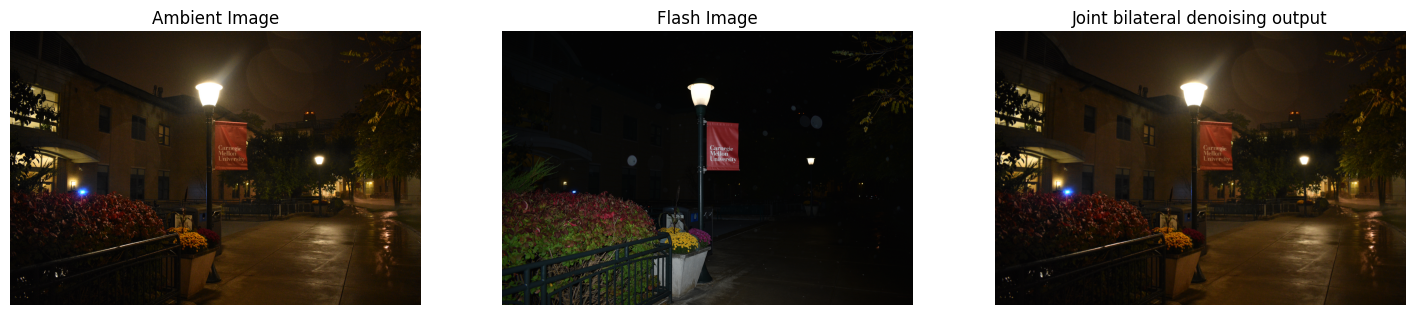

In [20]:
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(Aimg, cmap='gray')
plt.title('Ambient Image')
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(Flash_img, cmap='gray')
plt.title('Flash Image')
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(jb, cmap='gray')
plt.title('Joint bilateral denoising output')
plt.axis('off')
plt.savefig('q3_jb.png', bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


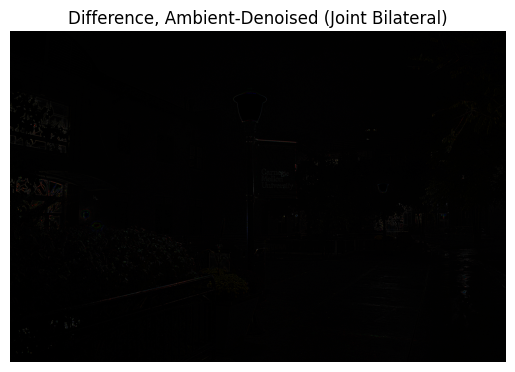

In [25]:
plt.imshow(Aimg-jb, cmap='gray')
plt.title('Difference, Ambient-Denoised (Joint Bilateral)')
plt.axis('off')
plt.savefig('q3_difference.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


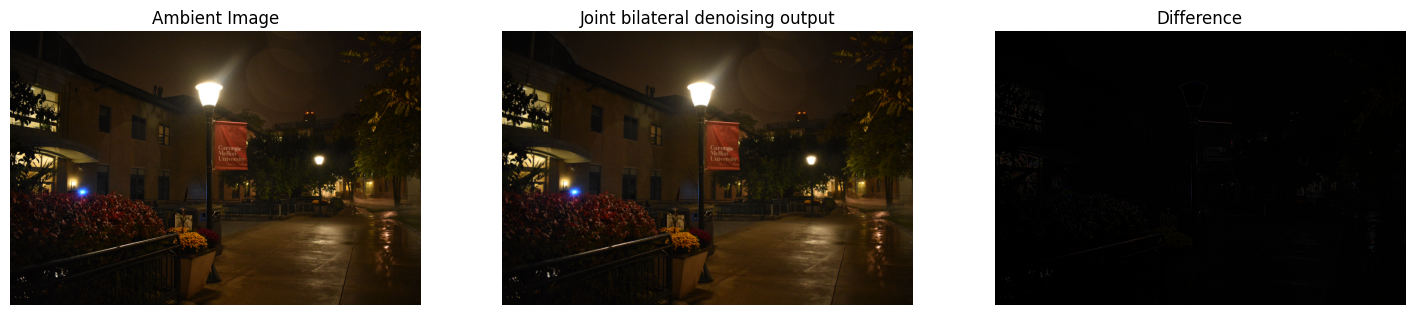

In [24]:
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(Aimg, cmap='gray')
plt.title('Ambient Image')
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(jb, cmap='gray')
plt.title('Joint bilateral denoising output')
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(Aimg-jb, cmap='gray')
plt.title('Difference')
plt.axis('off')
plt.savefig('q3_difference.png', bbox_inches='tight')
plt.show()

6 4000 6000
J_filtered_channel ((4000, 6000), -34037.30461073671, 233021.32274321257)
J_filtered_channel ((4000, 6000), -78305.6600043357, 15139.692537404815)
J_filtered_channel ((4000, 6000), -17852.53176962008, 46423.47131929038)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


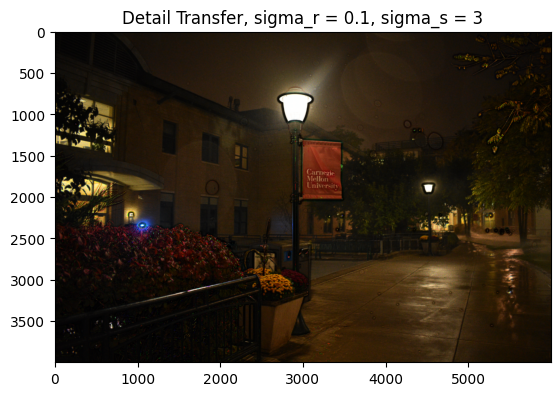

In [26]:
# F_Base = basic bilateral filter on flash image
sigma_s = 10
sigma_r = 0.2
eta = 0.02 
F_base = piecewise_bilateral(Flash_img, Flash_img, sigma_r, sigma_s)
F_detail_highw = (Flash_img + eta) / (F_base + eta)
A_detail_highw = np.multiply(jb, F_detail_highw)

plt.imshow(A_detail_highw, cmap='gray')
plt.title('Detail Transfer, sigma_r = 0.1, sigma_s = 3')
plt.savefig('q3_detail_transfer.png', bbox_inches='tight')

11 4000 6000
J_filtered_channel ((4000, 6000), -1241.8245320371902, 983.3117564019136)
J_filtered_channel ((4000, 6000), -13015.808488926243, 3926.2778339531183)
J_filtered_channel ((4000, 6000), -121218.22866630559, 1876.1472257577752)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


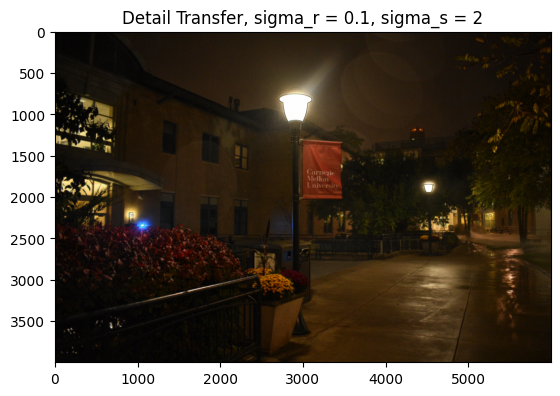

In [28]:
# F_Base = basic bilateral filter on flash image
sigma_s = 2
sigma_r = 0.1
eta = 0.02 
F_base = piecewise_bilateral(Flash_img, Flash_img, sigma_r, sigma_s)
F_detail_highw = (Flash_img + eta) / (F_base + eta)
A_detail_highw = np.multiply(jb, F_detail_highw)

plt.imshow(A_detail_highw, cmap='gray')
plt.title('Detail Transfer, sigma_r = 0.1, sigma_s = 2')
plt.savefig('q3_detail_transfer_final_.png', bbox_inches='tight')

In [7]:
# final image 
sigma_s = 3
sigma_r = 0.1
jb = piecewise_bilateral(Aimg, Flash_img, sigma_r, sigma_s)
plt.imshow(jb, cmap='gray')
plt.title('Joint Bilateral, sigma_r = 0.1, sigma_s = 3')
plt.savefig('jb.png', bbox_inches='tight')

11 2048 3072
J_filtered_channel ((2048, 3072), -778.5548572414767, 3123.8082338504887)


KeyboardInterrupt: 

Observation: bilateral filter has more noise as compared to joint bilateral filter. The latter blurs by implementing the edge-stopping function on flash image which has more detail. It is more robust to noise as the flash image having less noise is used to select the details (implement the intensity gaussian function for edge-stopping). Visualizing the difference between output of bilateral and joint bilateral, we get the noise difference showing merit of joint bilateral filter: 

Notice the contrast is visibly better.
<br>
As per the paper, $g_{\sigma_r}(F_p - F_s)$ will chose proper weights as the flash has more details and prevent over or under blurring of the ambient image. Next, I try using $\sigma_r = 0.1\%$ of range of values, i.e. 0.001. 

<br>

**Detail Transfer**
<br>
For generating $F_{Detail}$: as $\sigma_r, \sigma_s$ are increased, $F_{Base}$ is more smooth, hence $F_{Detail}$ has sharper detail. Very high values result in haloing effects as $F_{Base}$ reduces to gaussian filter. 

In [ ]:
# final image 
sigma_s = 3
sigma_r = 0.01
jb_1e_2 = piecewise_bilateral(Aimg, Flash_img, sigma_r, sigma_s)
plt.imshow(jb_1e_2, cmap='gray')
plt.title('Joint Bilateral, sigma_r = 0.01, sigma_s = 3')
plt.savefig('jb_1e_2.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


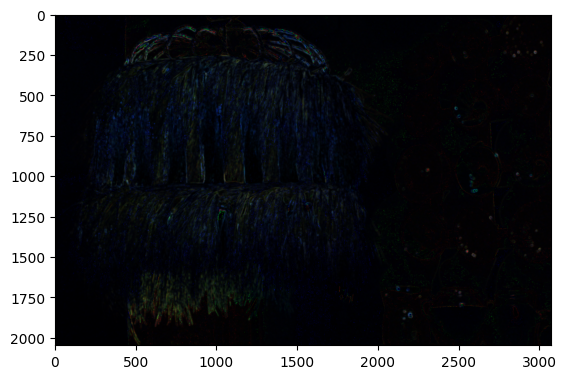

In [193]:
plt.imshow(out_bilateral-jb, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


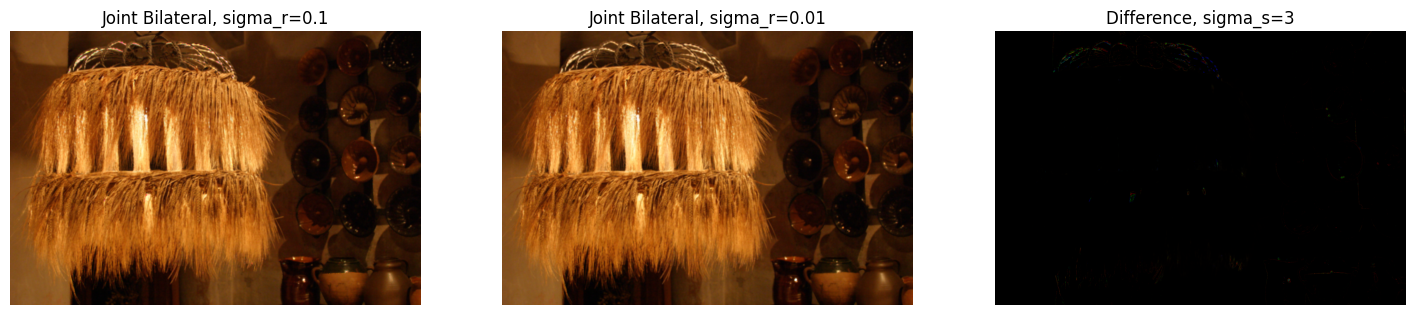

In [16]:
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(jb, cmap='gray')
plt.title('Joint Bilateral, sigma_r=0.1')
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(jb_1e_2, cmap='gray')
plt.title('Joint Bilateral, sigma_r=0.01')
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(jb-jb_1e_2, cmap='gray')
plt.title('Difference, sigma_s=3')
plt.axis('off')
plt.savefig('bjb_sigmas_differ', bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


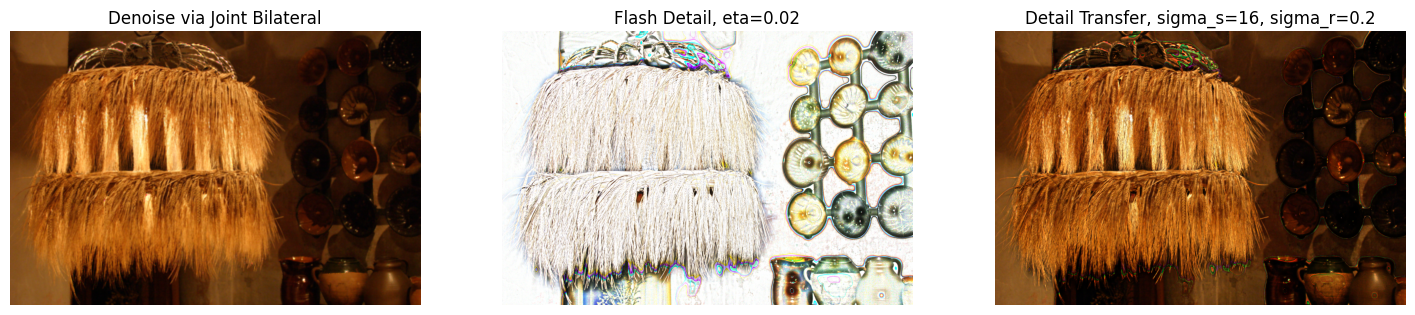

In [28]:
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(jb, cmap='gray')
plt.title('Denoise via Joint Bilateral')
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(F_detail_highw, cmap='gray')
plt.title('Flash Detail, eta=0.02')
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(A_detail_highw, cmap='gray')
plt.title('Detail Transfer, sigma_s=16, sigma_r=0.2')
plt.axis('off')
plt.savefig('detail_transfer_highw', bbox_inches='tight')
plt.show()

In [23]:
# F_Base = basic bilateral filter on flash image
sigma_s = 1
sigma_r = 0.05

def detail_transfer(Flash_img, A_NR, sigma_r, sigma_s):
    eta = 0.02
    F_base = piecewise_bilateral(Flash_img, Flash_img, sigma_r, sigma_s)
    F_detail = (Flash_img + eta) / (F_base + eta)
    A_detail = np.multiply(A_NR, F_detail)
    plt.imshow(A_detail_loww, cmap='gray')
    plt.title('Detail Transfer, sigma_r = 0.1, sigma_s = 3')
    # plt.savefig('detail_transfer.png', bbox_inches='tight')

6 2048 3072
J_filtered_channel ((2048, 3072), -7297.152519985747, 20442.39596211157)
J_filtered_channel ((2048, 3072), -35855.46313890144, 2639.582617552975)
J_filtered_channel ((2048, 3072), -1919.2004598640804, 7634.056121591155)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Detail Transfer, sigma_r = 0.1, sigma_s = 3')

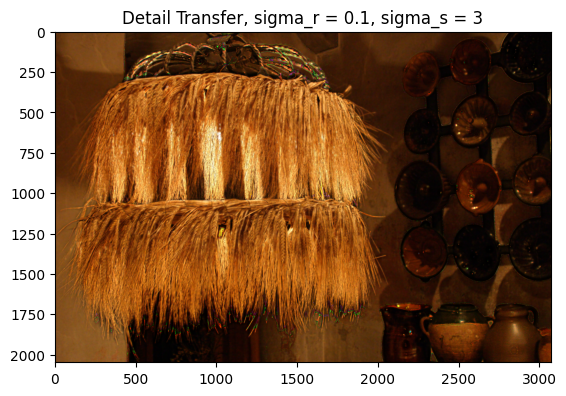

In [9]:
# F_Base = basic bilateral filter on flash image
sigma_s = 8
sigma_r = 0.2
eta = 0.02
F_base = piecewise_bilateral(Flash_img, Flash_img, sigma_r, sigma_s)
F_detail_highw = (Flash_img + eta) / (F_base + eta)
A_detail_highw = np.multiply(jb, F_detail_highw)

plt.imshow(A_detail_highw, cmap='gray')
plt.title('Detail Transfer, sigma_r = 0.1, sigma_s = 3')
# plt.savefig('detail_transfer.png', bbox_inches='tight')